/Users/sarahfisher/opt/anaconda3/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


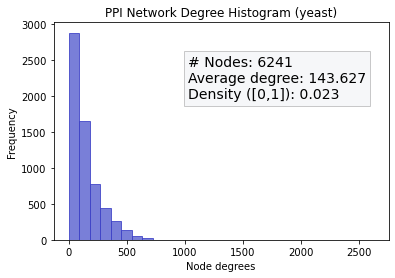

In [1]:
# import statements
import numpy as np
import copy
from ipynb.fs.full.data_explore import DataExplorer
from collections import Counter
import pprint
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
import operator
from math import log

In [2]:
class PrintColors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
    APPROACH_TITLE = BOLD + OKBLUE
    NBORHOOD_SIZE = WARNING
    
    @classmethod
    def print(self, msg, msgn="", color=None):
        if not color:
            color = PrintColors.BOLD
            
        print(f"{color}{msg}{PrintColors.ENDC} {msgn}")

In [3]:
class FunctionPrediction():
    def __init__(self, organism_name):
        # get all the annotation, adjacency list data from the explorer class
        self.data_explorer = DataExplorer(organism_name)
    
    # used to get r-neighborhood of protein
    def get_nborhood(self, protein, r, df="set"):
        if r == 1:
            fnl_nborhood = [
                nbor for (nbor, score) in self.data_explorer.adj_list[protein]
            ]

            if df == "set":
                return set(fnl_nborhood), set(fnl_nborhood)
            else:
                return fnl_nborhood, fnl_nborhood

        accum, last_nborhood = self.get_nborhood(protein, r - 1, df)

        fnl_nborhood = []

        for protein in last_nborhood:
            for (nbor, score) in self.data_explorer.adj_list[protein]:
                fnl_nborhood.append(nbor)

        if df == "set":
            return set.union(set(accum), set(fnl_nborhood)), set(fnl_nborhood)
        else:
            return accum + fnl_nborhood, fnl_nborhood
    
    # majority approach function predictor
    def majority_rule(self, protein_id_list, r=1):
        # input
            # protein_id_list : List = list of unknown proteins whose functions we predict
            # r : int = radius neighborhood to consider
        # output
            # cluster_assignments : Dict = dictionary of (protein_id, function list) key-value pairs
            
        PrintColors.print("MAJORITY APPROACH", color=PrintColors.APPROACH_TITLE)
        
        def expected_label_weight(cluster_id, n):
            # calculate the expected value of # of proteins with cluster `cluster_id` in a group of size `n`
                # E(# of proteins with `cluster_id` | size = n) = P(protein has `cluster_id`) * (size)
                #                                               = (# with `cluster_id` / # total) * (size)
            return (self.data_explorer.cluster_sizes[cluster_id] / len(self.data_explorer.adj_list)) * n
        
        def hishigaki_label(protein_id, n=15):
            cluster_score_dict = {} # dict to keep track of a cluster's score
            
            # get the neighborhood of this current protein
            total_nbh, recent_nbh = self.get_nborhood(protein_id, r, df="set")
            nborhood_size = len(total_nbh)
            
            PrintColors.print("WORKING NBORHOOD SIZE:", f"{nborhood_size} ({protein_id})", color=PrintColors.NBORHOOD_SIZE)

            
            # find all clusters present within nborhood
            clusters = [] 
            
            for nbor in total_nbh:
                if nbor not in protein_id_list: # only add clusters of a neighbor if neighbor is a "known" protein
                    clusters += self.data_explorer.annotation_list[nbor]
                
            cluster_counts = dict(Counter(clusters)) # count how many times a cluster appears in the neighborhood
            
            for cluster in clusters:
                expected_frequency = expected_label_weight(cluster, nborhood_size)
                observed_frequency = cluster_counts[cluster]
                
                # calculate scoring metric
                cluster_score = (observed_frequency - expected_frequency) / expected_frequency
                cluster_score_dict[cluster] = cluster_score
            
            # sort the scored clusters in increasing order
            zipped_dict = [(cluster, cluster_score_dict[cluster]) for cluster in cluster_score_dict]
            zipped_dict_sorted = sorted(zipped_dict, key = lambda tup: tup[1])
            
            # determine the winners by reversing the sorted cluster list, so the winners have the highest metric
            winners = ([cluster for (cluster, score) in zipped_dict_sorted][::-1])
            winners_scores = [cluster_score_dict[i] for i in winners]
            
            return winners
        
        cluster_assignments = {}
        
        for protein in protein_id_list:
            cluster_assignments[protein] = hishigaki_label(protein)
        
        return cluster_assignments
            
    # functional flow function predictor
    def functional_flow(self, protein_id_list, t=2):
        # input
            # protein_id_list : List = list of unknown proteins whose functions we predict
            # t : int = # of iterations to run flow sim for
        # output
            # cluster_assignments : Dict = dictionary of (protein_id, function list) key-value pairs
            
        PrintColors.print("FLOW APPROACH", color=PrintColors.APPROACH_TITLE)
    
        working_nborhood = set([])
        protein_id_list = set(protein_id_list)
        
        for protein_id in protein_id_list:
            total_nbh, recent_nbh = self.get_nborhood(protein_id, t, df="set")
            working_nborhood.update(total_nbh)
        
        working_nborhood = working_nborhood.difference(protein_id_list)
        
        PrintColors.print("WORKING NBORHOOD SIZE:", f"{len(working_nborhood)} ({protein_id})", color=PrintColors.NBORHOOD_SIZE)

        observed_clusters = set() # all clusters observed in the neighborhood
        
        for protein in working_nborhood:
            observed_clusters.update(set(self.data_explorer.annotation_list[protein]))
        
        # we start by picking some list of proteins that we want to know the function of
        # we also start with some known protein functions of nodes in the network
        # we fill the known nodes with infinite water at t=0
        # for t timesteps, we simulate the flow of water out of the known nodes, along edges, to proteins of
        # unknown function, and at t=t, we look at how much water has reached unknown nodes
        # (the flow volume between nodes is determined by edge weight)
        
        resoviors = {0: {}} # fill the nodes at t = 0 according to known function or not
        
        # resoviors dict keeps track of resoviors at each timestep
        # at a given timestep i, for each node u, we track the amount in the resovior for function a that u has
        
        for protein in working_nborhood:
            function_dict = {}

            for cluster in observed_clusters:
                if cluster in self.data_explorer.annotation_list[protein]:
                    function_dict[cluster] = 2 ** 100
                else:
                    function_dict[cluster] = 0.0

            resoviors[0][protein] = function_dict
        
        for protein in protein_id_list:
            function_dict = {}
            
            for cluster in observed_clusters:
                function_dict[cluster] = 0.0

            resoviors[0][protein] = function_dict
                        
        def edge_capacity(u, v, a, t):
            cluster_size = self.data_explorer.cluster_sizes[a]
            
            if t == 0: return 0
            if resoviors[t - 1][u][a] <= resoviors[t - 1][v][a]:
                return 0
            else:
                uv_weight = 0
                
                for (protein, score) in self.data_explorer.adj_list[u]:
                    if protein == v:
                        uv_weight = score
                
                u_weights = sum([score for (_, score) in self.data_explorer.adj_list[u]])
                
                return min(
                    uv_weight,
                    (uv_weight / u_weights)
                ) 
       
        # initialize the label scoring dictionary
        label_score_dict = {}
        
        for protein in protein_id_list:
            label_score_dict[protein] = {}
            
            for cluster in observed_clusters:
                label_score_dict[protein][cluster] = 0.0
                
        # iterate through working_nborhood + protein_id_list
        iterated_proteins = working_nborhood.union(protein_id_list)
        
        # build the resoviors
        for i in range(1, t + 1):
            resovior_i = copy.deepcopy(resoviors[i - 1])
            
            for protein in iterated_proteins:
                for cluster in observed_clusters:
                    amt_entered = sum([edge_capacity(nbor, protein, cluster, i) 
                      for (nbor, _) in self.data_explorer.adj_list[protein] if nbor in resovior_i])
                    
                    amt_left = sum([edge_capacity(protein, nbor, cluster, i) 
                      for (nbor, _) in self.data_explorer.adj_list[protein] if nbor in resovior_i])
                    
                    resovior_i[protein][cluster] = resoviors[i - 1][protein][cluster] + (amt_entered - amt_left)
                    
                    if protein in protein_id_list:
                        label_score_dict[protein][cluster] += amt_entered # add the amount entered to the label scoring
                    
            resoviors[i] = resovior_i
            
        # determine winning clusters for unknown proteins
        cluster_assignments_dict = {}
        
        for protein in protein_id_list:
            cluster_assignments_dict[protein] = [
                (cluster, label_score_dict[protein][cluster]) for cluster in label_score_dict[protein]
            ]
        
        cluster_assignments = {}
        
        for protein in cluster_assignments_dict:
            score_list = cluster_assignments_dict[protein]
            sorted_score_list = [cluster for (cluster, score) in sorted(score_list, key = lambda tup: tup[1])]
            
            cluster_assignments[protein] = sorted_score_list[::-1]
        
        # determine the winners by reversing the sorted cluster list, so the winners have the highest metric
        return cluster_assignments
    
    def alignment_approach(self, protein_id_list, r=1):
        # input
            # protein_id_list : List = list of unknown proteins whose functions we predict
            # r : int = radius neighborhood to consider
        # output
            # cluster_assignments : Dict = dictionary of (protein_id, function list) key-value pairs
            
        PrintColors.print("ALIGNMENT APPROACH", color=PrintColors.APPROACH_TITLE)
        
        # use BLOSUM62 for match/mismatch penalties and a -2 gap open, -1 gap extend penalty for use in
        # affine global alignment of amino acid strings
        scoring_matrix = matlist.blosum62
        
        def single_alignment(protein_id, r=r):
            if protein_id not in self.data_explorer.sequences:
                return []
            
            total_nbh, recent_nbh = self.get_nborhood(protein_id, r, df="set")
            score_list = {}
            
            PrintColors.print("WORKING NBORHOOD SIZE:", f"{len(total_nbh)} ({protein_id})", color=PrintColors.NBORHOOD_SIZE)

            # perform global alignment of all neighbors against alignment of protein and assign it
            # the functions of whichever protein score best against it
            for nbor in recent_nbh:
                if nbor not in protein_id_list:
                    try:
                        alignments = pairwise2.align.globalds(self.data_explorer.sequences[protein_id], 
                                                              self.data_explorer.sequences[nbor], 
                                                              scoring_matrix,
                                                              -2, -1
                                                             )
                        score_list[nbor] = max([algn.score for algn in alignments])
                    except KeyError:
                        # couldnt find nbor sequence
                        pass
                    
            winner = max(score_list.items(), key=operator.itemgetter(1))[0]
            return self.data_explorer.annotation_list[winner]
        
        cluster_assignments = {}
        
        for protein in protein_id_list:
            cluster_assignments[protein] = single_alignment(protein)
        
        return cluster_assignments

### Usage of ``FunctionPrediction`` class
To create a new instance of the class, create a new variable with the organism name (same as organism name used to instantiate the DataExplorer class; will be the name of the folder which contains the PPI info):
```
function_predictor = FunctionPrediction("organism_name")
```

To perform the majority approach with a radius `r` and list of proteins to predict `p`, run the function:
```
majority_approach_results = function_predictor.majority_rule(p, r=r)
```

To perform functional flow for `t` iterations and list of proteins to predict `p`, run the function:
```
functional_flow_results = function_predictor.functional_flow(p, t=t)
```
To perform sequence alignment approach with a radius `r` and list of proteins to predict `p`, run the function:
```
alignment_approach_results = function_predictor.alignment_approach(p, r=r)
```

In all methods, the function returns a dictionary of the form:
```
{protein_id: [list of functions (by name) scored and sorted in descending order]}
```

In [4]:
function_predictor = FunctionPrediction("yeast")